In [394]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# data inlezen

### load data

In [395]:
geboorte_files = list()
for file in os.listdir(datadir):
    if not file == "2019-2-29.csv":
        new_df = pd.read_csv(os.path.join(datadir,file))
        new_df['geboorte_datum'] = file[:-4]
    else:
        wrong_df = pd.read_csv(os.path.join(datadir,file))
        continue
    geboorte_files.append(new_df)
df_geboortes_raw = pd.concat(geboorte_files, ignore_index = True)

### we copy the raw dataframe so we do not have to go to the dir anymore and format date fields and add day of year

In [396]:
alle_geboortes_2019_pd = df_geboortes_raw.copy()
alle_geboortes_2019_pd['geboorte_datum'] = pd.to_datetime(alle_geboortes_2019_pd['geboorte_datum'], format="%Y-%m-%d")
alle_geboortes_2019_pd['verwachte datum'] = pd.to_datetime(alle_geboortes_2019_pd['verwachte datum'], format="%m/%d/%Y")
alle_geboortes_2019_pd['dag van het jaar'] = ((alle_geboortes_2019_pd['geboorte_datum'] 
                                              - datetime(2018,12,31)).dt.days).astype(int)

### add reason to wrong_df

In [397]:
wrong_df['reden'] = 'gn schrikkeljaar'

### we copy all data to a raw dataframe for the check of unisex

In [400]:
all_dfs=list()
all_dfs.append(df_geboortes_raw.copy())
all_dfs.append(wrong_df)
all_data_raw_pd = pd.concat(all_dfs, ignore_index = True)

### plot the number of births per day of the year

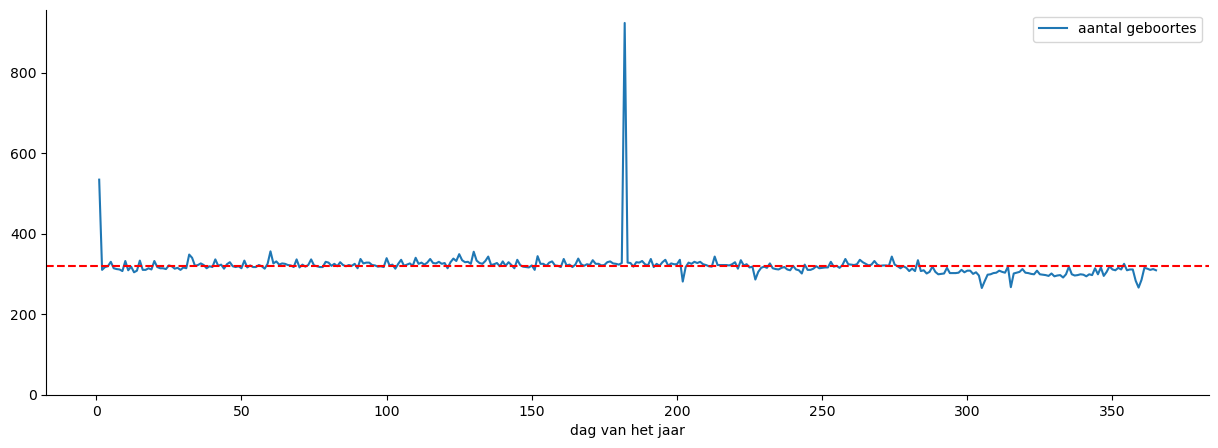

In [401]:
fig, axs = plt.subplots(figsize=(15,5))
average_births_all = alle_geboortes_2019_pd['dag van het jaar'].value_counts().mean()
geboortes_plot = pd.DataFrame(alle_geboortes_2019_pd['dag van het jaar'].value_counts())
geboortes_plot.sort_values(by='dag van het jaar').plot(ax = axs, xlabel='dag van het jaar')
axs.spines[['top', 'right']].set_visible(False)
axs.axhline(average_births_all, color='r', ls='--')
axs.set_ylim(ymin=0)
axs.legend(['aantal geboortes']);

### split of the outliers and add them to the wrong_df

In [403]:
outliers_in_geboortes=(datetime(2019,1,1),datetime(2019,7,1))
outliers_df = alle_geboortes_2019_pd.query('geboorte_datum in @outliers_in_geboortes')
outliers_df.loc[:,'reden']=outliers_df.loc[:,'geboorte_datum']
wrong_dfs=list()
wrong_dfs.append(outliers_df)
wrong_dfs.append(wrong_df)
wrong_df = pd.concat(wrong_dfs, ignore_index = True)

/var/folders/pq/zr9wl4z56zj76cn6wqf6ysr80000gn/T/ipykernel_1400/2919918148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df.loc[:,'reden']=outliers_df.loc[:,'geboorte_datum']


### plotting the same visualisation but without the outliers of jan 1st and july 1st

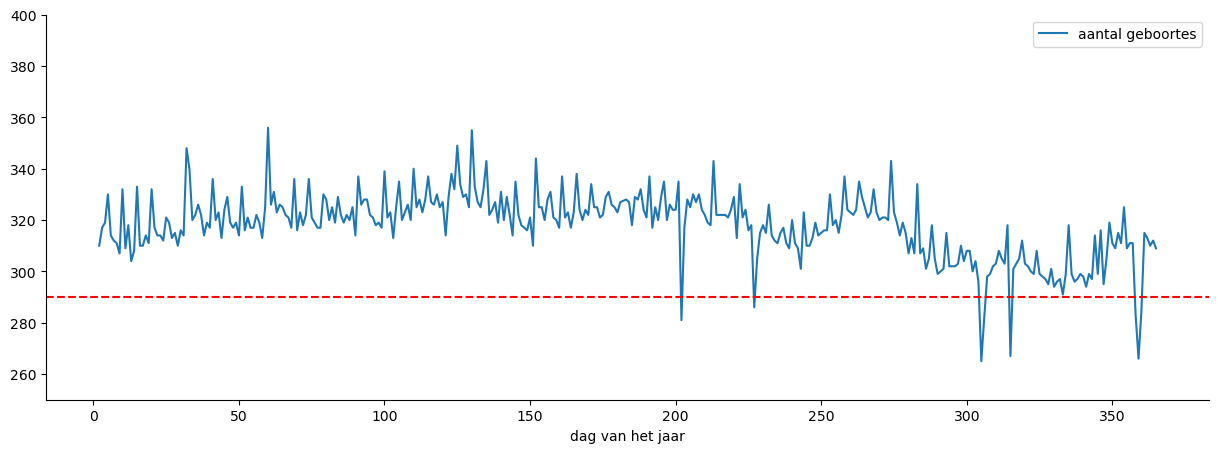

In [404]:
outlier_line = average_births_all/1.1039
fig, axs = plt.subplots(figsize=(15,5))
geboortes_without_outliers = alle_geboortes_2019_pd.query('geboorte_datum not in @outliers_in_geboortes')
geboortes_plot = pd.DataFrame(geboortes_without_outliers['dag van het jaar'].value_counts())
geboortes_plot.sort_values(by='dag van het jaar').plot(ax = axs, xlabel='dag van het jaar')
axs.spines[['top', 'right']].set_visible(False)
axs.axhline(outlier_line, color='r', ls='--')
axs.set_ylim(ymin=250, ymax=400)
axs.legend(['aantal geboortes']);

### find the outliers in the second part of the year

In [405]:
for geboorte_dag, group in alle_geboortes_2019_pd.groupby('geboorte_datum'):
    count_of_births = group['dag van het jaar'].value_counts()
    if count_of_births.values[0] <290:
        print(geboorte_dag)

2019-07-21 00:00:00
2019-08-15 00:00:00
2019-11-01 00:00:00
2019-11-02 00:00:00
2019-11-11 00:00:00
2019-12-24 00:00:00
2019-12-25 00:00:00
2019-12-26 00:00:00


### split the complete dataframe according to gender

In [406]:
def split_by_gender():
    geslacht_man= "Mannelijk"
    geslacht_vrouw = "Vrouwelijk"
    alle_mannen_2019_pd = all_data_raw_pd.query('geslacht == @geslacht_man').reset_index(drop=True)
    alle_vrouwen_2019_pd = all_data_raw_pd.query('geslacht == @geslacht_vrouw').reset_index(drop=True)
    return alle_mannen_2019_pd, alle_vrouwen_2019_pd

### create a unisex dataframe

In [407]:
def find_unisex_names(male_df, female_df):
    merged_df= pd.merge(male_df,female_df, left_on='naam', right_on='naam',  how='inner')
    merged_df = (pd.DataFrame(merged_df['naam'].unique().copy())).reset_index(drop=True).rename(columns={0:'naam'})
    return merged_df

#### the most popular name according to the first comparison

In [408]:
merged_df= pd.merge(alle_mannen_2019_pd,alle_vrouwen_2019_pd, left_on='naam', right_on='naam',  how='inner')
merged_df['naam'].value_counts().sort_values(ascending = False).head(1)

naam
Dominique    38232
Name: count, dtype: int64

#### the most popular unisex name from the male dataframe

In [409]:
merged_male_df= pd.merge(alle_mannen_2019_pd,unisex_names, left_on='naam', right_on='naam',  how='inner')
merged_male_df.query('geslacht == @geslacht_man')['naam'].value_counts().sort_values(ascending = False).head(1)

naam
Maxime    206
Name: count, dtype: int64

#### the most popular unisex name from the female dataframe

In [410]:
merged_female_df= pd.merge(alle_vrouwen_2019_pd,unisex_names, left_on='naam', right_on='naam',  how='inner')
merged_female_df.query('geslacht == @geslacht_vrouw')['naam'].value_counts().sort_values(ascending = False).head(1)

naam
Dominique    236
Name: count, dtype: int64

### create the true unisex dataframe

In [411]:
def create_real_unisex_global(unisex_names):
    real_unisex_list = list()
    for unisex_naam in unisex_names['naam']:
        if (alle_mannen_2019_pd.query('naam == @unisex_naam')['naam'].size 
              <=1.5*alle_vrouwen_2019_pd.query('naam == @unisex_naam')['naam'].size) and \
        (alle_vrouwen_2019_pd.query('naam == @unisex_naam')['naam'].size 
              <= 1.5*alle_mannen_2019_pd.query('naam == @unisex_naam')['naam'].size ):
            real_unisex_list.append(unisex_naam)
    df_real_unisex = pd.DataFrame(real_unisex_list)
    df_real_unisex = df_real_unisex.reset_index(drop=True).rename(columns={0:'naam'})
    return df_real_unisex

### find the true unisex male and female list

In [438]:
def unisex_names_count(unisex_names_df):
    #call function to 
    alle_mannen_2019_pd, alle_vrouwen_2019_pd = split_by_gender()
    # merge the given unisex df with both the all male and all female df to get a
    merged_male_df= pd.merge(alle_mannen_2019_pd,unisex_names_df, left_on='naam', right_on='naam',  how='inner')
    merged_female_df= pd.merge(alle_vrouwen_2019_pd,unisex_names_df, left_on='naam', right_on='naam',  how='inner')
    #get the top one result of both dfs and we are going to return these
    male_topname = (merged_male_df.query('geslacht == @geslacht_man')['naam']
                                .value_counts().sort_values(ascending = False))
    female_topname = (merged_female_df.query('geslacht == @geslacht_vrouw')['naam']
                                .value_counts().sort_values(ascending = False))
    return male_topname, female_topname

### load the male and female dataframes

In [432]:
mannen_df, vrouwen_df = split_by_gender()

In [433]:
unisex_names = find_unisex_names(mannen_df,vrouwen_df)

In [434]:
df_real_unisex = create_real_unisex_global(unisex_names)

In [439]:
top_unisex_name_male, top_unisex_name_female = unisex_names_count(df_real_unisex)

### what is the top unisex name for male and female?

In [440]:
print(top_unisex_name_female.head(1),
top_unisex_name_male.head(1))

naam
Dominique    233
Name: count, dtype: int64 naam
Dominique    161
Name: count, dtype: int64


In [441]:
print('number of occurences for male: ',top_unisex_name_male.sum(), 'number of occurences for female: ',top_unisex_name_female.sum())

number of occurences for male:  226 number of occurences for female:  288


### calculate the relative occurence of unisex name per gender

In [442]:
total_relative = top_unisex_name_female/vrouwen_df['naam'].count()*100 + top_unisex_name_male/ mannen_df['naam'].count()*100
relative_female = (top_unisex_name_female/vrouwen_df['naam'].count()*100)/total_relative*100
relative_male = (top_unisex_name_male/ mannen_df['naam'].count()*100)/total_relative*100
relative_merged_df = pd.merge(relative_male,relative_female, left_on='naam', right_on='naam',  how='inner').rename(columns={'count_x':'male_percent','count_y':'female_percent'})

### visualize the relative occurence of the unisex name per gender

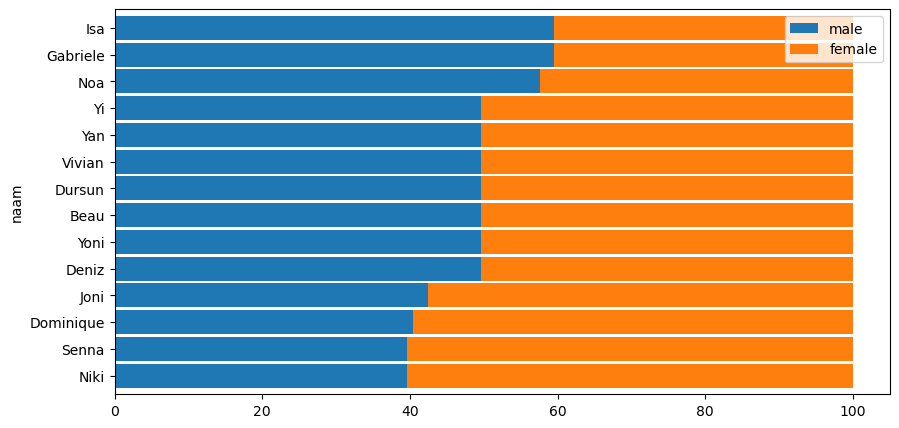

In [443]:
fig, axs = plt.subplots(figsize=(10,5))
relative_merged_df.sort_values(by='female_percent', ascending=False).plot.barh( ax=axs, stacked=True, width=0.9)
axs.legend(['male','female'])

### number of expexted births for the year

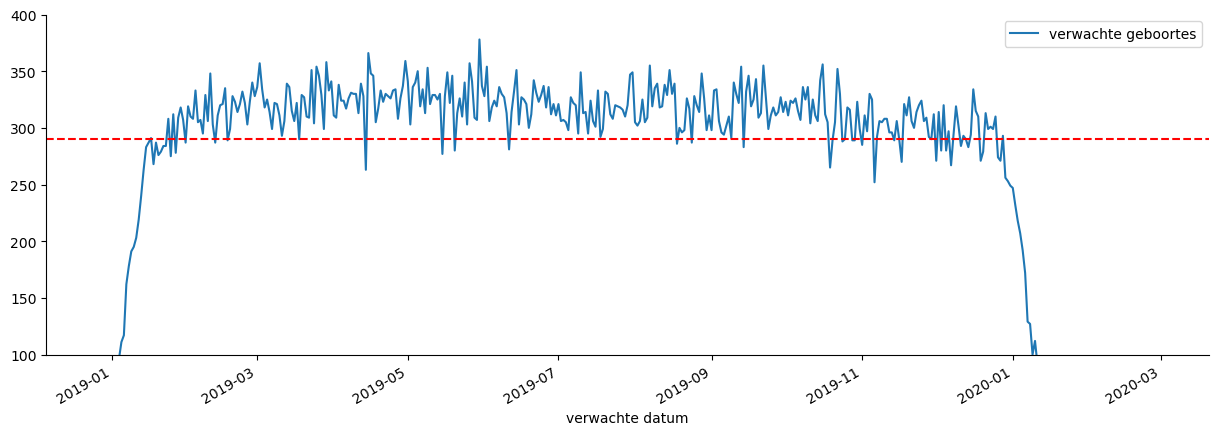

In [426]:
outlier_line = average_births_all/1.1039
fig, axs = plt.subplots(figsize=(15,5))
geboortes_without_outliers = alle_geboortes_2019_pd.query('geboorte_datum not in @outliers_in_geboortes')
verwachte_geboortes_plot = pd.DataFrame(geboortes_without_outliers['verwachte datum'].value_counts())
verwachte_geboortes_plot.sort_values(by='verwachte datum').plot(ax = axs, xlabel='verwachte datum')
axs.spines[['top', 'right']].set_visible(False)
axs.axhline(outlier_line, color='r', ls='--')
axs.set_ylim(ymin=100, ymax=400)
axs.legend(['verwachte geboortes']);